<a href="https://colab.research.google.com/github/kwon0915/Kwon-Hyeong-Joong/blob/master/auto_mpg_dl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#auto-mpg_dl : 자동차 관련 평가 데이터 - 연비예측(회귀)
#module Name : auto_mpg_dl.py
# 1. mpg:           continuous
# 2. cylinders:     multi-valued discrete
# 3. displacement:  continuous
# 4. horsepower:    continuous
# 5. weight:        continuous
# 6. acceleration:  continuous
# 7. model year:    multi-valued discrete
# 8. origin:        multi-valued discrete
# 9. car name:

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# from sklearn.ensemble import RandomForestClassifier
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense

from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, roc_auc_score,precision_score,recall_score, roc_curve, classification_report,precision_recall_curve
from sklearn.preprocessing import StandardScaler,RobustScaler,MinMaxScaler, Binarizer, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold

import warnings
warnings.filterwarnings(action="ignore")

np.random.seed(121)
tf.random.set_seed(121)

In [ ]:
def CHART_PLOT_HISTORY(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure(figsize=(8,12))

    plt.subplot(2,1,1)
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.plot(hist['epoch'], hist['mse'],    label = 'mse') #mse : 평균제곱오차, 회귀분석이어서 사용했을 가능성이 있음(평균부터 얼마가 떨아져있는가)
    plt.plot(hist['epoch'], hist['val_mse'],label = 'val_mse') #val_mse : 평가용 평균제곱 오차
    plt.legend()

    plt.subplot(2,1,2)
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.plot(hist['epoch'], hist['loss'],    label = 'loss')
    plt.plot(hist['epoch'], hist['val_loss'],label = 'val_loss')
    plt.legend()
    plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cols = ['mpg','cylinders','display','power','weight','accel','year','origin','name']
#df = pd.read_csv("auto-mpg.data", na_values = "?", comment='\t', names=cols, skipinitialspace=True, quotechar='"', delim_whitespace=True ) #?:null_value처리. 구분자는 공백 넣기,skipinitialspace:true로 하면 공백 만나도 계속 진행, quotechar:"로 묶은 문장은 한 컬럼으로 처리
#df = pd.read_csv("auto-mpg.data", na_values='?', delimiter=r"\s+", names=cols,)
df = pd.read_csv('/content/drive/MyDrive/self/auto-mpg.data', na_values='?', delim_whitespace=True, names=cols,)  #na_values='?' : 결측치값을 - 로 했는가, delim_whitespace=True : true로 해주면 구분기호가 불규칙한 것을 해결

In [ ]:
print(df.shape)

(398, 9)


In [ ]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   mpg        398 non-null    float64
 1   cylinders  398 non-null    int64  
 2   display    398 non-null    float64
 3   power      392 non-null    float64
 4   weight     398 non-null    float64
 5   accel      398 non-null    float64
 6   year       398 non-null    int64  
 7   origin     398 non-null    int64  
 8   name       398 non-null    object 
dtypes: float64(5), int64(3), object(1)
memory usage: 28.1+ KB
None


In [ ]:
df.head()

,mpg,cylinders,display,power,weight,accel,year,origin,name
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,ford torino


In [ ]:
#1.결측처리
print(df.describe().T)

           count         mean         std  ...     50%       75%     max
mpg        398.0    23.514573    7.815984  ...    23.0    29.000    46.6
cylinders  398.0     5.454774    1.701004  ...     4.0     8.000     8.0
display    398.0   193.425879  104.269838  ...   148.5   262.000   455.0
power      392.0   104.469388   38.491160  ...    93.5   126.000   230.0
weight     398.0  2970.424623  846.841774  ...  2803.5  3608.000  5140.0
accel      398.0    15.568090    2.757689  ...    15.5    17.175    24.8
year       398.0    76.010050    3.697627  ...    76.0    79.000    82.0
origin     398.0     1.572864    0.802055  ...     1.0     2.000     3.0

[8 rows x 8 columns]


In [ ]:
print(df.isnull().sum()) #power 6개 null -> mean으로 채우기

mpg          0
cylinders    0
display      0
power        6
weight       0
accel        0
year         0
origin       0
name         0
dtype: int64


In [ ]:
df["power"]=df["power"].fillna(df["power"].mean())

In [ ]:
print(df.isna().sum())

mpg          0
cylinders    0
display      0
power        0
weight       0
accel        0
year         0
origin       0
name         0
dtype: int64


In [ ]:
print(df["power"][:10]) #제대로 되었는가 확인

0    130.0
1    165.0
2    150.0
3    150.0
4    140.0
5    198.0
6    220.0
7    215.0
8    225.0
9    190.0
Name: power, dtype: float64


In [ ]:
#2.name - object
print(df["name"].nunique()) #305개:이름이 가지각색-> 딱히 분석에 의미있어 보이진 않음. 이름 drop 시킴. 그대신 origin으로 차국적 분리

305


In [ ]:
df.drop("name", inplace=True, axis=1) #분석시 필요가 없다고 판단하여 버림
print(df.info())
#origin-1:USA 2:EU 3:JP -> OneHotEncoding
#target:mpg

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   mpg        398 non-null    float64
 1   cylinders  398 non-null    int64  
 2   display    398 non-null    float64
 3   power      398 non-null    float64
 4   weight     398 non-null    float64
 5   accel      398 non-null    float64
 6   year       398 non-null    int64  
 7   origin     398 non-null    int64  
dtypes: float64(5), int64(3)
memory usage: 25.0 KB
None


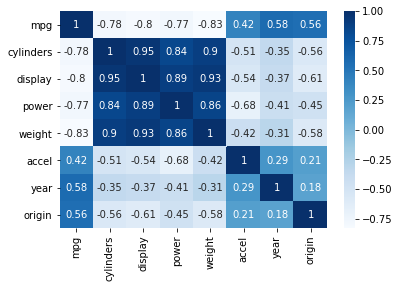

In [ ]:
#======================분석 : 결측X, ObjectX
#상관분석
sns.heatmap(df.corr(), annot=True, fmt=".2g", cmap="Blues")
plt.show() #실린더, 배기량, 마력, 무게 -> mpg와 음의 상관관계가 강한편 + 또한 서로 상관관계가 높으므로 PCA 처리 해야함
#year, origin도 어느정도 양의 상관관계는 있음

In [ ]:
def BUILD_EVAL(X_data, y, str=None, epoch=100):
    model = Sequential()
    model.add(Dense(32, input_dim=X_data.shape[1], activation='relu')) #X_data의 열만 받아옴(컬럼갯수: 차수), X_data.shape[1] : x데이터의 열만 가지고 옴
    model.add(Dense(16, activation='relu'))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(1))  # 회귀에서는 activation 필요 없음
    print(model.summary())
                  #loss='mean_squared_error' : 평균제곱오차              #mae : 평균절대오차
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse', 'mae']) #optimizer 여러개를 복합해서 넣어도 상관없지만 학습시간이 상당히 오래 걸림. 피쳐가 적을 경우에는 overfitting우려 -> 데이터 용량이 클 경우에만. 보통은 adam 많이 사용

    from keras.callbacks import EarlyStopping
    #val_loss 로 10번을 참고 멈춤
    early_stop = EarlyStopping(monitor='val_loss', patience=10) #보통 mse, mae, loss, val_mse, val_mae, val_loss 6가지가 있음 -> 학습한 점수와 검증한 점수에서 검증점수를 봐야 제대로 확인이 가능하다.(학습은 epoch을 오래하면 오래할 수록 점수가 올라감) 따라서 보통 val로 monitor
    res = model.fit(X_data, y, validation_split=0.1, epochs=epoch, callbacks=[early_stop])

    loss, mse, mae = model.evaluate(X_data, y)  # 학습점수. validation 따로 잡고 싶으면 model.history.history로 dict key값으로 빼면 됨 #7:3으로 강제로 나눴을 때에는 X_test, y_test #모델 확정되면 확정된 모델로 predict
    print("epoch 100회 평균 loss {:.4f} mse{:.4f} rmse{:.4f} mae{:.4f}".format(loss, mse, np.sqrt(mse),
                                                                            mae))  # rmse가 0에 가까울수록 좋은 것. rmse9.42면 실체 연비가 100이면 우리 모델은 91로 예측한 것
    CHART_PLOT_HISTORY(res)  # dataset이 작아서 에폭 3에서 걸려버림.
    # res.history['val_loss']


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                256       
_________________________________________________________________
dense_1 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 929
Trainable params: 929
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
12/12 [==============================] - 1s 26ms/step - loss: 18826.8104 - mse: 18826.8104 - mae: 126.3381 - val_loss: 860.6019 - val_mse: 860.6019 - val_mae: 26.5035
Epoch 2/100
12/12 [==============================] - 0s 7ms/step - loss:

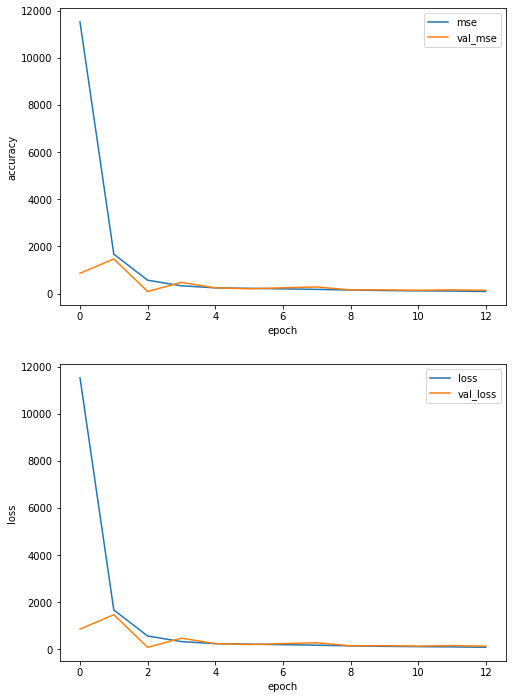

In [ ]:
y = df["mpg"] #target
X = df.drop("mpg", axis=1)
BUILD_EVAL(X, y, "----1차----")

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 32)                832       
_________________________________________________________________
dense_5 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 9         
Total params: 1,505
Trainable params: 1,505
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
12/12 [==============================] - 1s 22ms/step - loss: 83444.9261 - mse: 83444.9261 - mae: 272.8929 - val_loss: 10519.6406 - val_mse: 10519.6406 - val_mae: 102.0135
Epoch 2/100
12/12 [==============================] - 0s 6ms/s

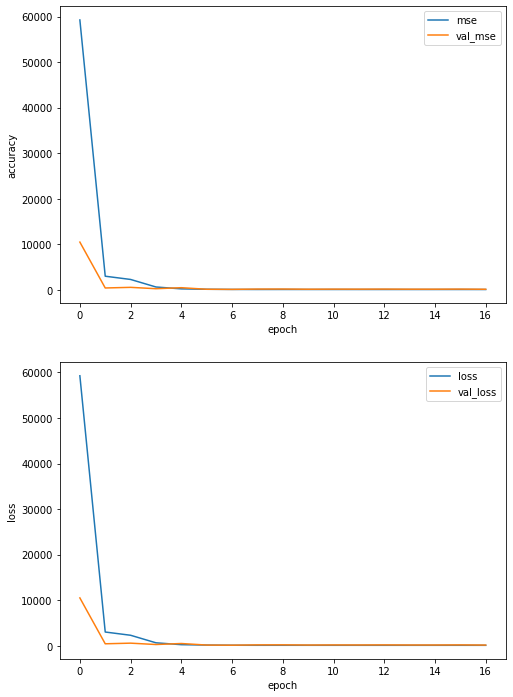

In [ ]:
from sklearn.preprocessing import OneHotEncoder
enc_col = ['cylinders', 'year', 'origin'] #cylinders', 'year', 'origin 을 OH
# pd.get_dummies() //결측 + 글자->숫자(LabelEncoder)  OneHotEncoder(001)
oh_X = pd.get_dummies(X, columns=enc_col)
BUILD_EVAL(oh_X, y, "----인코딩---")

In [ ]:
# ------------------------------------- np.log1p scaling
log_col = ['display','power','weight'] #로그스케일링 - 광범위한 값의 수치를 줄여서 변화폭을 알기가 쉽게 함
# from sklearn.preprocessing import StandardScaler
# sc = StandardScaler()
# sc.fit_transform()
# BUILD_EVAL(sc_X)

In [ ]:
for c in log_col: #np.log1p : 로그 변환
    oh_X[c] = np.log1p(np.array(oh_X[c])) #matrix나 dataframe채로 못넣음 -> np.array해서 넣어야함
    #아래는 y도 로그로 변환 (x를 해줬기에 y도 같이 해줘서 비교할 수 있게 함)
oh_y = np.log1p(np.array(y)) #oh_X에는 타겟이 없으므로 oh_y(log변환한 y) -> 타겟데이터 먼저 스케일링 하기 ->  submit할때는 원복시키기

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 32)                832       
_________________________________________________________________
dense_9 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_10 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 9         
Total params: 1,505
Trainable params: 1,505
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
12/12 [==============================] - 1s 39ms/step - loss: 0.8060 - mse: 0.8060 - mae: 0.7692 - val_loss: 0.2028 - val_mse: 0.2028 - val_mae: 0.3668
Epoch 2/100
12/12 [==============================] - 0s 6ms/step - loss: 0.2715 -

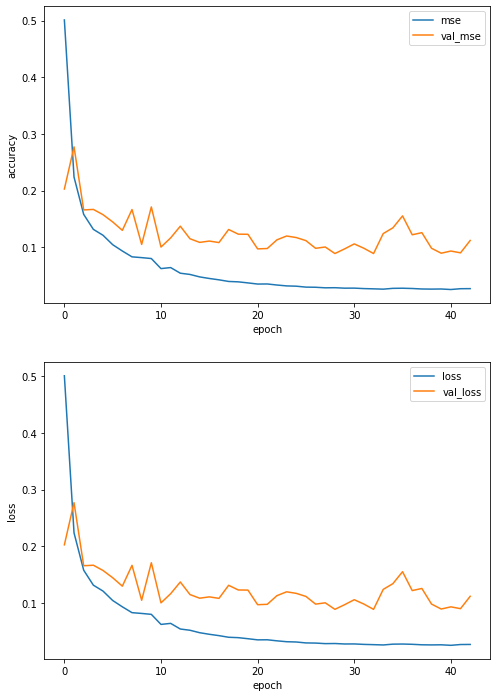

In [ ]:
BUILD_EVAL(oh_X, oh_y, "----스케일링---")